In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from scipy import stats
import tensorflow as tf
import math
import random

fps=120
threshold=1
moving_avg_len=10
filter_value = 20
length=200


def readFileData(file):
    column_names = ['wmx1', 'wmy1', 'wmz1']

    data = pd.read_csv(file, skiprows = 1 , names = column_names)
 
    wx = data["wmx1"]
    wy = data["wmy1"]
    wz = data["wmz1"]

    records=movingavg(wx,wy,wz)

    return np.dstack([wx,wy,wz])[0]

def readData(directory):
    records = []
    labels = np.empty(0)
    
    allFiles = glob.glob("*.csv")
    for i,file in enumerate(allFiles):
        fileName = os.path.basename(file)
        print("file name is", fileName,"\nnum is",i)
        (name, ext) = os.path.splitext(fileName)
        print("name is ", name,"\next is ",ext)
        parts = name.split("_")
        print("parts[1]",parts[1])
        if (True):
            label = parts[1]
            fileData = readFileData(file)
            print("file datat is ",fileData)
            records.append(fileData)
            labels = np.append(labels, label)

    return (records, labels)

def movingavg(x,y,z):
    x_avg = np.zeros(moving_avg_len)/moving_avg_len
    y_avg = np.zeros(moving_avg_len)/moving_avg_len
    z_avg = np.zeros(moving_avg_len)/moving_avg_len
    x_avg = np.convolve(x,x_avg,'same')
    y_avg = np.convolve(y,y_avg,'same')
    z_avg = np.convolve(z,z_avg,'same')
    
    return [x_avg,y_avg,z_avg]

def splitData(records):##sungshil
    print("records is ",records[0][0])
    term=fps//4
    record_sum=[]
    record=[]
    record_all=[]
    ct=0
    sum_now=0.0
    sum_pre=0.0
    start=0
    end=0
    
    for i in range((len(records[0])//(term))-100):
        sum=0.0
        record_x=np.empty(shape=[1],dtype=float)
        record_y=np.empty(shape=[1],dtype=float)
        record_z=np.empty(shape=[1],dtype=float)
        for j in range(fps):
            record_x=np.append(record_x,records[0][term*i+j][0])
            record_y=np.append(record_y,records[0][term*i+j][1])
            record_z=np.append(record_z,records[0][term*i+j][2])
        for k in range(fps-2):
            sum=sum+(record_x[k]-record_x[k+1])**2+(record_y[k]-record_y[k+1])**2+(record_z[k]-record_z[k+1])**2
            
        sum_pre=sum_now
        sum_now=sum
        record_sum.append(sum)
        if (sum_pre<threshold and sum_now>threshold):
            
            ct=ct+1
            start=term*i
            print("start",start)
        if (sum_pre>threshold and sum_now<threshold):
            end=term*i  
            print("end",end)
            print("step is " ,ct)
            print("length of end-start",(end-start))
            s=[]
            for k in range(end-start):
                #t=(records[0][term*i+j+k])
                #print("t is",t)
                s.append(records[0][start+k])
                #print("s is ",s)
            record_all.append(s)
             
    print("number of patterm : ",ct)
    print("average is",np.average(record_sum))
    print("number of term",len(record_sum))
  
    plt.plot(record_sum[1500:2500])
    
    return record_all

def getRecordsMaxLength(records):
    maxLen = 0
    for record in records:
        if (len(record) > maxLen):
            maxLen = len(record)
        
    return maxLen

def shortenRecordsLen(records, length):
    ret=[]
    rec_len=len(records)
    
    for index in range(len(records)):
        s=[]
        record = records[index]
        if len(record) > length and len(record)<3000:
            for i in range(length):
                r=[]
                t=i*len(record)/length
                if t%1==0:
                    s.append(records[index][int(t)])
                else:
                    a=t//1
                    s1=t-a
                    s2=a+1-t
                    for i in range(3):
                        r.append(s1*records[index][int(a)][i]+s2*records[index][int(a)][i])
                    s.append(r) 
        
                
        ret.append(s)
        
    return ret

def weight_variable(shape):#가중치 생성
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):#편향 생성
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):#각 채널마다 활성곱 수행후 ReLu활성화 함수로 pass
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):#생성된 convolution층에 pooling 적용
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

file name is Converted_triangle_Goeun.csv 
num is 0
name is  Converted_triangle_Goeun 
ext is  .csv
parts[1] triangle
file datat is  [[-0.4037555 -0.4533244  0.123958 ]
 [-0.4037032 -0.453312   0.1240349]
 [-0.4036419 -0.4533651  0.1239233]
 ...
 [-0.5039639  0.2422239  0.3849714]
 [-0.5024952  0.233694   0.3909167]
 [-0.5009295  0.2242776  0.3971767]]
file name is Converted_triangle_Sua.csv 
num is 1
name is  Converted_triangle_Sua 
ext is  .csv
parts[1] triangle
file datat is  [[-0.4566614  0.3063586  0.4218905]
 [-0.4566169  0.3065761  0.4217441]
 [-0.4567036  0.3068056  0.4214881]
 ...
 [-0.4183478  0.3121404  0.2459875]
 [-0.4226401  0.3115721  0.245495 ]
 [-0.4270472  0.3110253  0.2447947]]
file name is Converted_triangle_Sungshil.csv 
num is 2
name is  Converted_triangle_Sungshil 
ext is  .csv
parts[1] triangle
file datat is  [[-0.4308836  0.285009   0.3843815]
 [-0.4309311  0.2851806  0.384151 ]
 [-0.4310462  0.2853804  0.3838755]
 ...
 [-0.4077535  0.3494152  0.3543387]
 [-0.4

start 31770
end 31890
step is  108
length of end-start 120
start 32130
end 32250
step is  109
length of end-start 120
start 32430
end 32580
step is  110
length of end-start 150
start 32730
end 32880
step is  111
length of end-start 150
start 33060
end 33180
step is  112
length of end-start 120
start 33270
end 33300
step is  113
length of end-start 30
start 33360
end 33510
step is  114
length of end-start 150
start 33720
end 33870
step is  115
length of end-start 150
start 33960
end 34110
step is  116
length of end-start 150
start 34290
end 34470
step is  117
length of end-start 180
start 34590
end 34740
step is  118
length of end-start 150
start 34920
end 35070
step is  119
length of end-start 150
start 35100
end 35160
step is  120
length of end-start 60
start 35250
end 35430
step is  121
length of end-start 180
start 35580
end 35730
step is  122
length of end-start 150
start 35910
end 36060
step is  123
length of end-start 150
start 36270
end 36360
step is  124
length of end-start 90


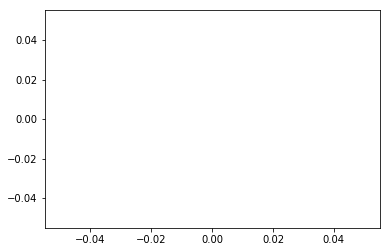

In [12]:
(records,labels) = readData("dr")
labels = np.asarray(labels)
print("len(labels) >> ",len(labels))
#print("size of ",len(records[0]))
#print("size of divide ",len(records[0])//40)
#records=filter_data(records)
records=splitData(records)
records=shortenRecordsLen(records, length)
print(records)
print(records[0])

#for i in range(len(records)):
   # plt.plot(records[i])